In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.transformations as trans
import nglview as nv
from tqdm import tqdm
from scipy.optimize import brentq

/opt/anaconda3/envs/personal/lib/python3.14/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
top = 'prd.tpr'
trj = 'prd.xtc'

u = mda.Universe(top, trj)

In [3]:
# calcualte pore center as the mean position of Acidic and Basic residues in constriction region
# and cr(constriction region) direction (xy projection) as the vector from the Basic (positive) to Acidic (negative) residues
u.trajectory[0]

segids = ['seg_0_PROA', 'seg_1_PROB', 'seg_2_PROC'] # 3 monomers
# ompc
# A_resids = [105, 109] # acidic residues (ASP105, GLU109)
# B_resids = [16, 37, 74, 124] # basic residues (LYS16, ARG37, ARG74, ARG124)
# ompf 
A_resids = [117, 113] # acidic residues (ASP105, GLU109)
B_resids = [16, 42, 82, 132] # basic residues (LYS16, ARG37, ARG74, ARG124)

pore_centers = [] # mean pore centers of 3 monomers, finally a array of shape (3, 3) (monomer * coordinates)
cr_directions = [] # cr vectors of 3 monomers, finally a array of shape (3, 3) (monomer * coordinates)

for segid in segids:
    pore_centers_seg = []
    cr_vectors_seg = []
    for ts in tqdm(u.trajectory):
        seg_chain = u.select_atoms(f'segid {segid} and name CA')
        seg_protein = u.select_atoms(f"segid {segid} and protein")

        A_res = seg_protein.residues[[i-1 for i in A_resids]]
        B_res = seg_protein.residues[[i-1 for i in B_resids]]
        A_CA = A_res.atoms.select_atoms("name CA")
        B_CA = B_res.atoms.select_atoms("name CA")

        A_com = A_CA.center_of_mass()
        B_com = B_CA.center_of_mass()
        
        cr_vector = A_com - B_com
        cr_vector[2] = 0
        cr_vector = cr_vector/np.linalg.norm(cr_vector)
        pore_center = (A_com + B_com)/2

        pore_centers_seg.append(pore_center)
        cr_vectors_seg.append(cr_vector)
    
    pore_centers_seg = np.array(pore_centers_seg)
    cr_vectors_seg = np.array(cr_vectors_seg)
    pore_centers.append(np.mean(pore_centers_seg, axis=0))
    cr_directions.append(np.mean(cr_vectors_seg, axis=0))

pore_centers = np.array(pore_centers)
cr_directions = np.array(cr_directions)
cr_directions = cr_directions / np.linalg.norm(cr_directions, axis=1, keepdims=True)

# define y direction as cr_directions
# x direction is perpendicular to y direction
y_directions = cr_directions
x_directions = np.array([-y_directions[:, 1], y_directions[:, 0], np.zeros(3)]).T
x_directions = x_directions / np.linalg.norm(x_directions, axis=1, keepdims=True)
z_directions = np.cross(x_directions, y_directions)
z_directions = z_directions / np.linalg.norm(z_directions, axis=1, keepdims=True)

100%|██████████| 374/374 [00:01<00:00, 274.53it/s]


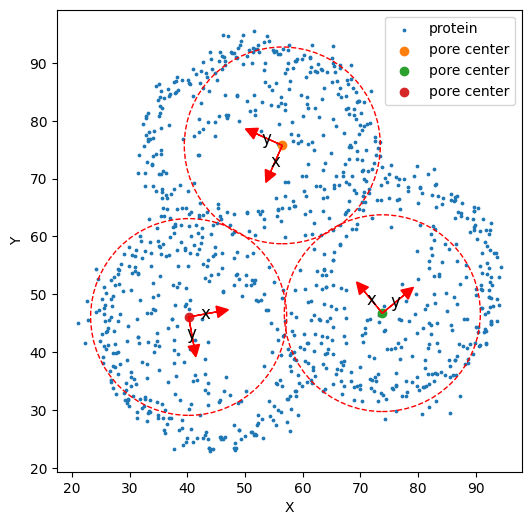

In [4]:
# visualize pore centers and cr directions
u.trajectory[0]

protein = u.select_atoms('protein and name CA').positions
waters = u.select_atoms('resname TIP3').positions

plt.figure(figsize=(6,6))
plt.scatter(protein[:,0], protein[:,1], s=3, label='protein')
plt.scatter(pore_centers[0][0], pore_centers[0][1], label='pore center')
plt.scatter(pore_centers[1][0], pore_centers[1][1], label='pore center')
plt.scatter(pore_centers[2][0], pore_centers[2][1], label='pore center')
# draw a circle that center at pore_center with radius 
plt.gca().add_patch(plt.Circle(pore_centers[0], 17, fill=False, color='r', linestyle='--'))
plt.gca().add_patch(plt.Circle(pore_centers[1], 17, fill=False, color='r', linestyle='--'))
plt.gca().add_patch(plt.Circle(pore_centers[2], 17, fill=False, color='r', linestyle='--'))
# draw cr_vector with arrows
for i in range(3):
    plt.arrow(pore_centers[i][0], pore_centers[i][1], y_directions[i][0]*5, y_directions[i][1]*5,
              head_width=2, head_length=2, fc='r', ec='r')
    plt.text(pore_centers[i][0] + y_directions[i][0]*3, pore_centers[i][1] + y_directions[i][1]*3, 'y', fontsize=12, ha='center', va='center')
    plt.arrow(pore_centers[i][0], pore_centers[i][1], x_directions[i][0]*5, x_directions[i][1]*5,
              head_width=2, head_length=2, fc='r', ec='r')
    plt.text(pore_centers[i][0] + x_directions[i][0]*3, pore_centers[i][1] + x_directions[i][1]*3, 'x', fontsize=12, ha='center', va='center')

plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [5]:
# distribution of water molecules in the cylindrical region
u.trajectory[0]

# setting: the selected water molecules are in the cylindrical region centered at each pore_center
cylinder_radius = 17
cylinder_height = 70
half_height = cylinder_height / 2

waters_in_cyls = [[] for _ in range(len(segids))] # list of shape (monomer, frame, water)

for i, segid in enumerate(segids):
    pore_center = pore_centers[i]
    
    for ts in tqdm(u.trajectory):
        waters = u.select_atoms('resname TIP3')
        O_atoms = waters.select_atoms('name OH2')
        r = O_atoms.positions - pore_center
        mask = (np.abs(r[:, 2]) < half_height) & (np.sqrt(r[:, 0]**2 + r[:, 1]**2) < cylinder_radius)
        hit_resids = np.unique(O_atoms[mask].resids)
        waters_in_cyls[i].append(u.select_atoms(f"resname TIP3 and resid {' '.join(map(str, hit_resids))}").positions)


100%|██████████| 374/374 [00:07<00:00, 48.83it/s]


In [6]:
# setting : each cylinder is divided into slices with thickness dz. A spherical probe is placed in the average of oxygen atoms of each slice
dz = 0.5
probe_radius = 7
v_w = 29.9 # volume of water molecule
mu = 2.35 # dipole moment of water molecule
P_all = [] # array of shape (monomer, slice, slab, dimension)

for i, segid in enumerate(segids):
    pore_center = pore_centers[i]
    z_min = pore_center[2] - half_height
    z_max = pore_center[2] + half_height
    x_direction = x_directions[i]
    y_direction = y_directions[i]
    z_direction = z_directions[i]
    
    P_seg = []
    for j, waters in enumerate(waters_in_cyls[i]):
        probe_centers = []
        for z in np.arange(z_min, z_max, dz):
            O_pos = waters[::3]
            mask = (O_pos[:, 2] > z) & (O_pos[:, 2] < z + dz)
            if np.sum(mask) > 0:
                probe_center = np.mean(O_pos[mask], axis=0)
                probe_centers.append(probe_center)
            else:
                probe_center = probe_centers[-1]
                probe_center[2] = z + dz/2
                probe_centers.append(probe_center)

        P_frame = []
        for k, probe_center in enumerate(probe_centers):
            O_pos = waters[::3]
            mask = (O_pos[:, 0] - probe_center[0])**2 + (O_pos[:, 1] - probe_center[1])**2 + (O_pos[:, 2] - probe_center[2])**2 < probe_radius**2
            num_O = np.sum(mask)
            O_slab = O_pos[mask]
            H1_slab = waters[1::3][mask]
            H2_slab = waters[2::3][mask]
            if num_O == 0:
                P = np.zeros(3)
            else:
                vec = (H1_slab + H2_slab)/2 - O_slab      # shape (N, 3)
                norm = np.linalg.norm(vec, axis=1, keepdims=True)
                unit_vec = vec / norm                     # shape (N, 3)
                dipole = unit_vec * mu                    # each water has |dipole| = mu
                P = np.sum(dipole, axis=0) / num_O / v_w
            P_x = np.dot(P, x_direction)
            P_y = np.dot(P, y_direction)
            P_z = np.dot(P, z_direction)
            P_frame.append(np.array([P_x, P_y, P_z]))
        P_frame = np.array(P_frame)
        P_seg.append(P_frame)
    P_seg = np.array(P_seg)
    P_all.append(P_seg)

P_all = np.array(P_all)

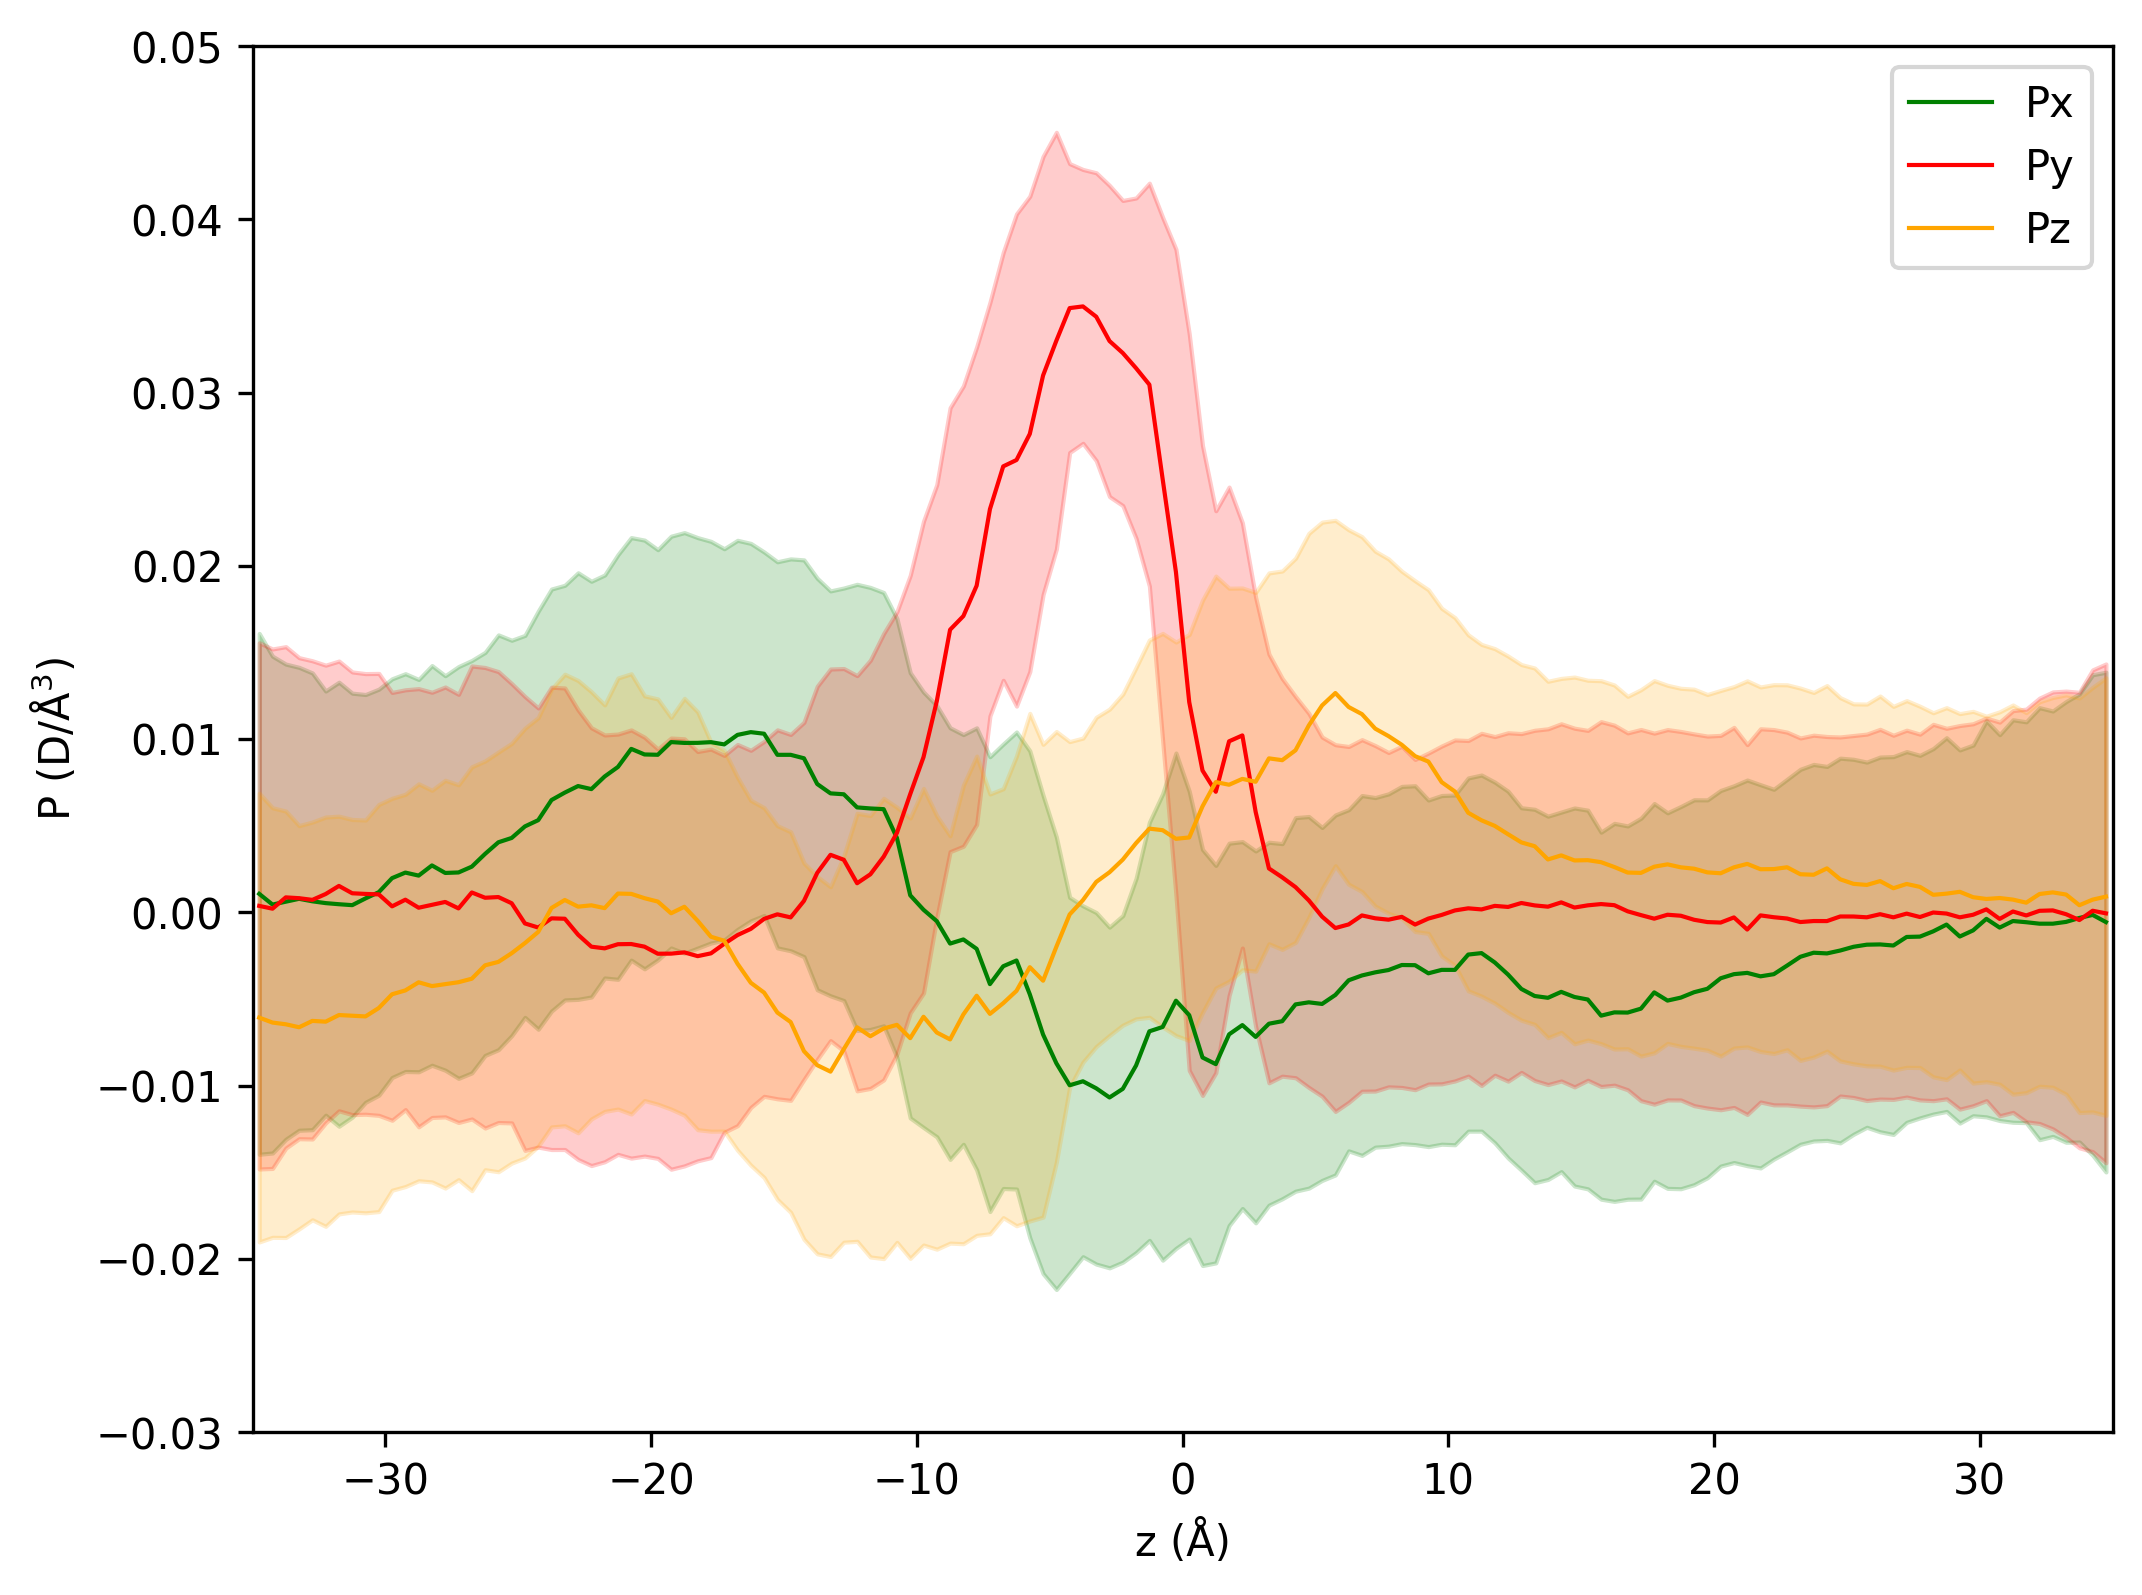

In [7]:
P_mean = np.mean(P_all, axis=(0, 1)) # array of shape (slab, dimension)
P_std = np.std(P_all, axis=(0, 1)) # array of shape (slab, dimension)

z = np.arange(z_min, z_max, dz) - np.mean(np.arange(z_min, z_max, dz))
plt.figure(figsize=(8,6), dpi=300)
plt.plot(z, P_mean[:, 0], label='Px', color='g', linewidth=1)
plt.fill_between(z, P_mean[:, 0] - P_std[:, 0], P_mean[:, 0] + P_std[:, 0], alpha=0.2, color='g')
plt.plot(z, P_mean[:, 1], label='Py', color='r', linewidth=1)
plt.fill_between(z, P_mean[:, 1] - P_std[:, 1], P_mean[:, 1] + P_std[:, 1], alpha=0.2, color='r')
plt.plot(z, P_mean[:, 2], label='Pz', color='orange', linewidth=1)
plt.fill_between(z, P_mean[:, 2] - P_std[:, 2], P_mean[:, 2] + P_std[:, 2], alpha=0.2, color='orange')
plt.ylim(-0.03, 0.05)
plt.xlim(-35, 35)
plt.xlabel('z (Å)')
plt.ylabel('P (D/Å$^3$)')
plt.legend()
plt.show()

In [8]:
def Langevin(x):
    x = x + 1e-10 # avoid division by zero
    return 1 / np.tanh(x) - 1/x

def Booth(E, a=0.00001, b=0.07, c=0.0907651):
    """
    Booth polarization for a *magnitude* of E.
    E can be scalar or array (we only care about |E| in this model).
    """
    E = np.asarray(E, dtype=float)
    E_abs = np.abs(E)
    return a * E_abs + b * Langevin(E_abs * c)

def invert_Booth(P_target, E_min=0.0, E_max=500.0):
    """
    Invert Booth: given P (which may be positive or negative),
    return E with the *same sign* as P. Magnitudes are related
    by Booth(|E|) = |P|.
    """
    P_target = float(P_target)
    sign = np.sign(P_target) if P_target != 0.0 else 0.0
    P_abs = abs(P_target)

    if P_abs < 1e-8:
        return 0.0

    def f(E):
        # E is taken as a magnitude here
        return Booth(E) - P_abs

    try:
        E_abs = brentq(f, E_min, E_max)
    except ValueError:
        # No sign change in [E_min, E_max] (e.g., saturation) → clip
        E_abs = E_max

    return sign * E_abs

# E = np.linspace(0.1, 500, 100)
# P = Booth(E)
# plt.xticks(np.arange(0, 501, 50))
# plt.ylim(0, 0.08)
# plt.xlim(0, 500)
# plt.plot(E, P)
# plt.show()

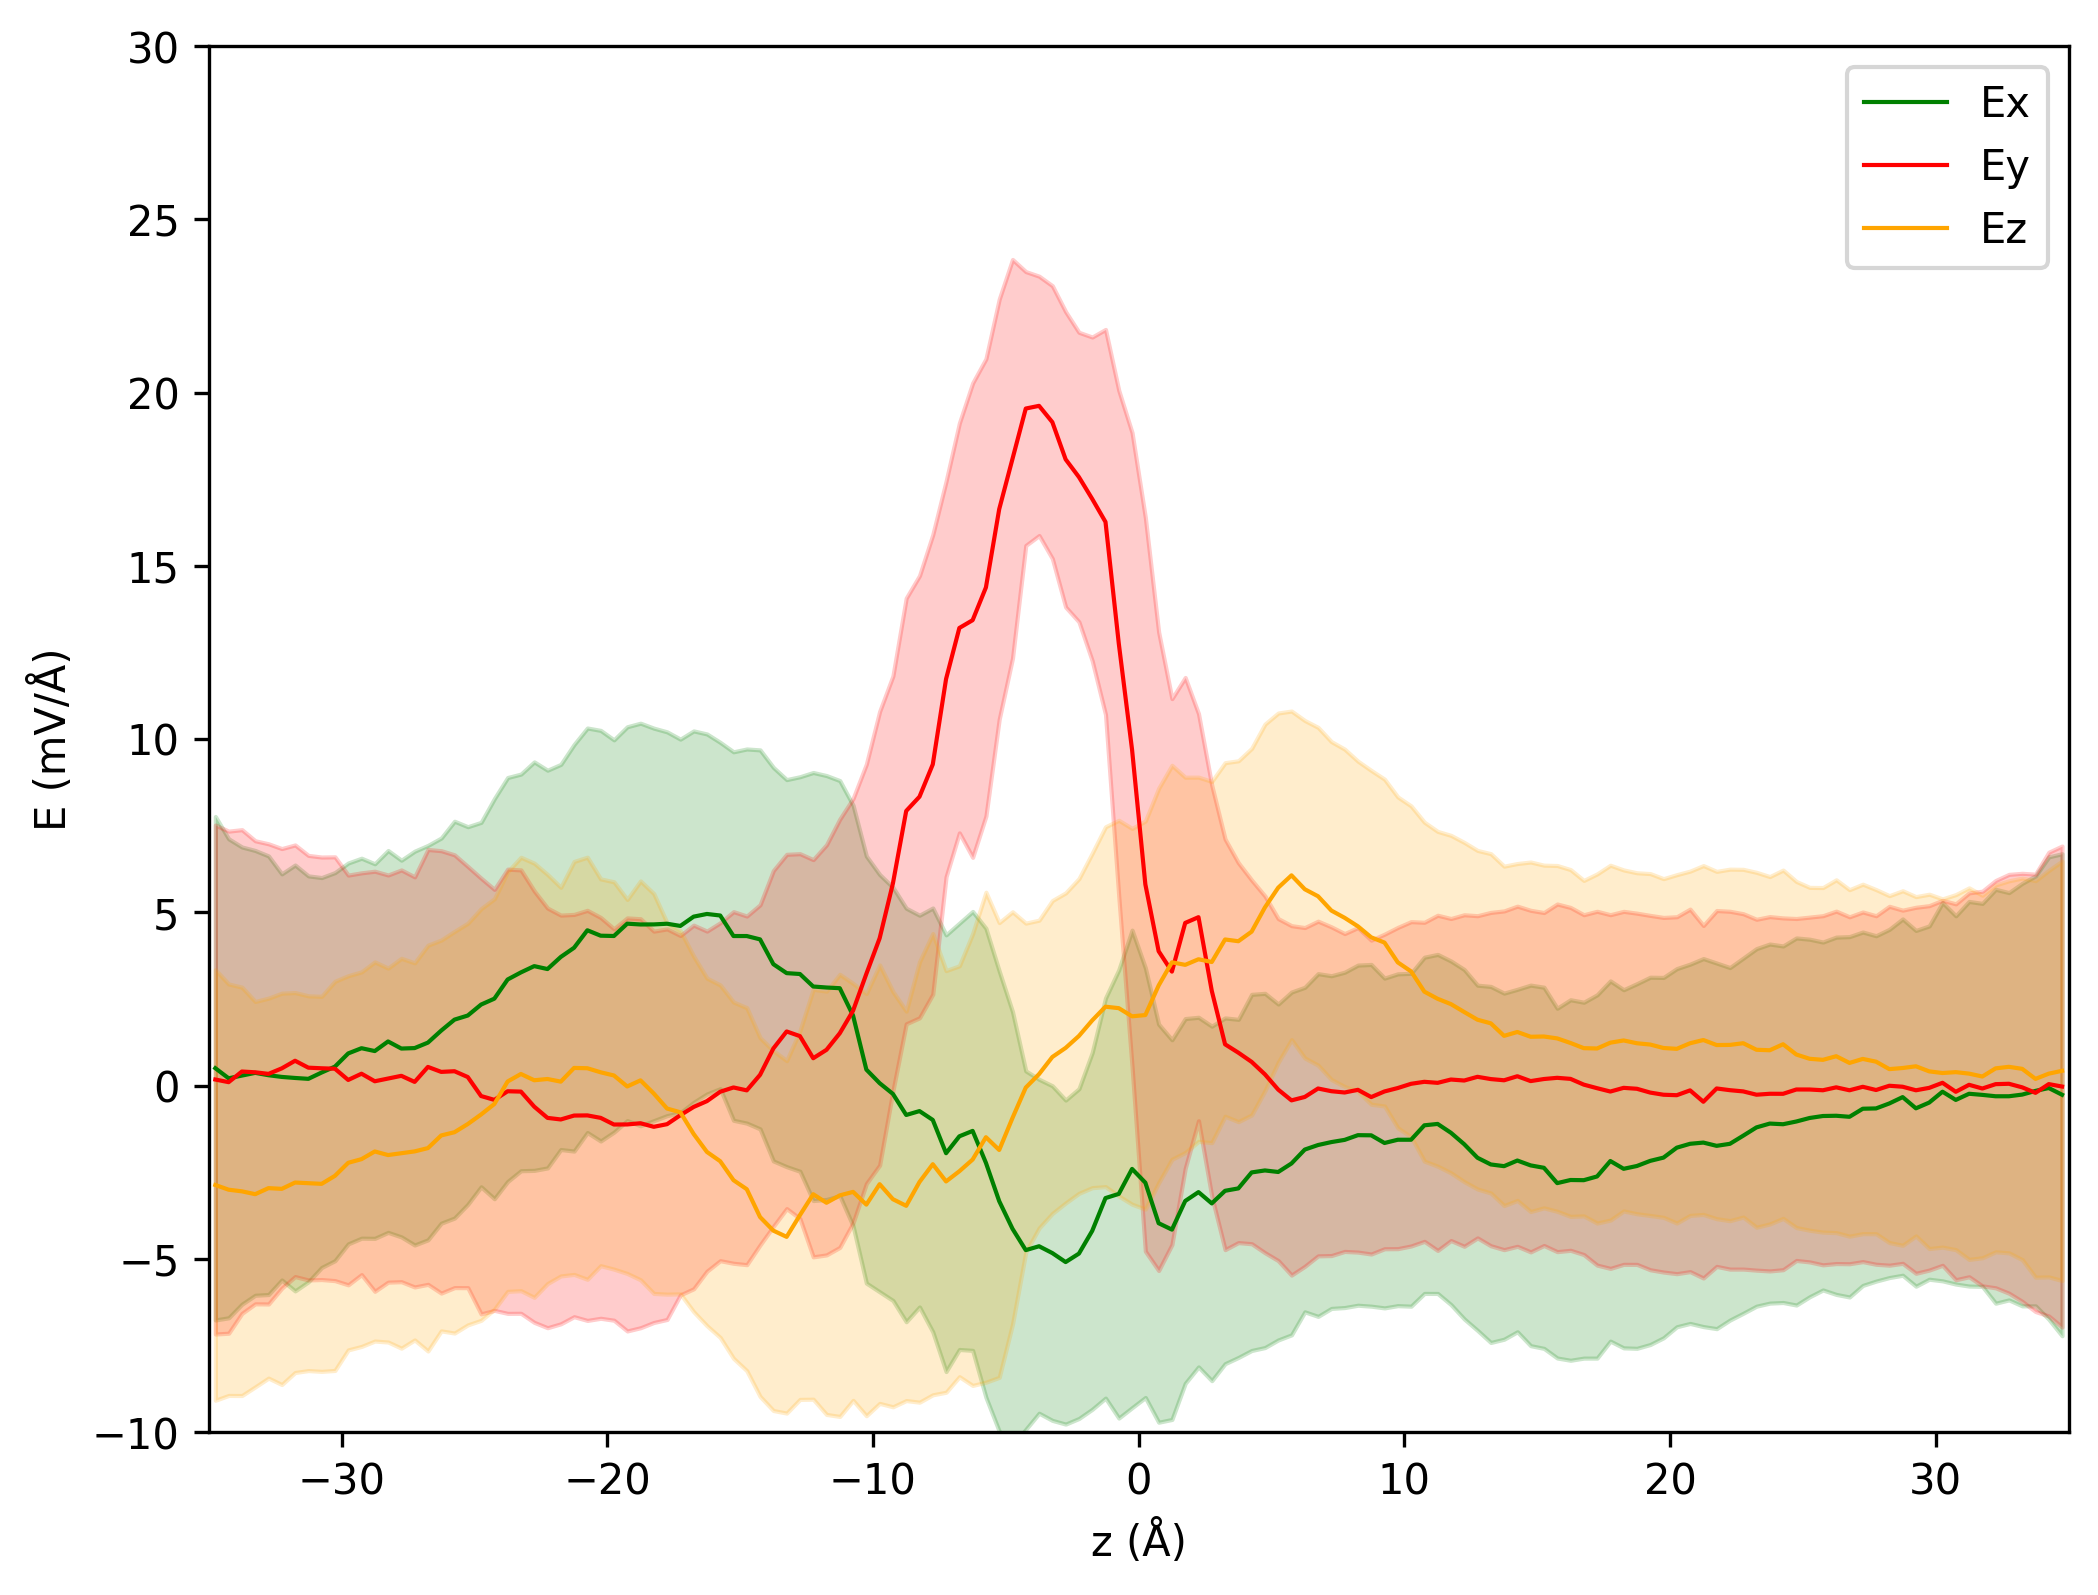

In [9]:
E_mean = np.vectorize(invert_Booth)(P_mean)
E_std = np.vectorize(invert_Booth)(P_std)

plt.figure(figsize=(8,6), dpi=300)
plt.plot(z, E_mean[:, 0], label='Ex', color='g', linewidth=1)
plt.fill_between(z, E_mean[:, 0] - E_std[:, 0], E_mean[:, 0] + E_std[:, 0], alpha=0.2, color='g')
plt.plot(z, E_mean[:, 1], label='Ey', color='r', linewidth=1)
plt.fill_between(z, E_mean[:, 1] - E_std[:, 1], E_mean[:, 1] + E_std[:, 1], alpha=0.2, color='r')
plt.plot(z, E_mean[:, 2], label='Ez', color='orange', linewidth=1)
plt.fill_between(z, E_mean[:, 2] - E_std[:, 2], E_mean[:, 2] + E_std[:, 2], alpha=0.2, color='orange')
plt.ylim(-10, 30)
plt.xlim(-35, 35)
plt.xlabel('z (Å)')
plt.ylabel('E (mV/Å)')
plt.legend()
plt.show()